In [1]:
import scanpy as sc

In [2]:
import pickle

In [3]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt

In [6]:
import sys
import os
from importlib import reload

# Add the path of your package
package_path = os.path.abspath("/Genomics/pritykinlab/tamjeed/github_packages/GlossPath/")
sys.path.insert(0, package_path)
package_path = os.path.abspath("/Genomics/pritykinlab/tamjeed/github_packages/Gloss/")
sys.path.insert(0, package_path)

In [7]:
def generate_pathways_dict(fn, mygenes, change_case = False):
    pathways = {}
    with open(fn, "r") as f:
        for line in f:
            line = line.strip()
            words = line.split("\t")
            if change_case:
                words = [ word.capitalize() for word in words]
            pathway = words[2:]
            pathway = list(set(pathway).intersection(mygenes))
            pathways[words[0]] = pathway
            #if len(pathway) < 200 and len(pathway) > 3:
            #    pathways[words[0]] = pathway
    return pathways

In [8]:
def get_hallmark_pathways(gene_ad):
    hallmark_pathways_path = '../pathway_collections/mouse_hallmark_genes.gmt.txt'
    mygenes = set(gene_ad.var.index)
    path_dict = generate_pathways_dict(hallmark_pathways_path, mygenes)
    return path_dict

def get_kegg_pathways(gene_ad):
    with open('../pathway_collections/kegg_pathways_sep18_2024.pkl', 'rb') as handle:
        kegg_gene_sets = pickle.load(handle)
    
    mygenes = set(gene_ad.var.index)
    for key, value in kegg_gene_sets.items():
        kegg_gene_sets[key] = list(set([gene for gene in value if gene in mygenes]))
        
    empty = []
    for key in kegg_gene_sets:
        if not kegg_gene_sets[key]:
            empty.append(key)

    for pathway in empty:
        kegg_gene_sets.pop(pathway)
        
    path_dict = kegg_gene_sets
    return path_dict

In [9]:
with open('../pathway_computations/cellchatdb.pickle', 'rb') as handle:
    cellchatdb = pickle.load(handle)
with open('../pathway_computations/cd40neighbors.pickle', 'rb') as handle:
    cd40neighbors = pickle.load(handle)

In [10]:
with open('../pathway_computations/random_neighbors.pickle', 'rb') as handle:
    random_neighbors = pickle.load(handle)

In [11]:
with open('../pathway_computations/humanbase_cd40neighbors.pickle', 'rb') as handle:
    humanbase_cd40neighbors = pickle.load(handle)

In [12]:
with open('../pathway_computations/cd40_filtered.pickle', 'rb') as handle:
    cd40_filtered_neighbors = pickle.load(handle)

In [13]:
with open('../pathway_computations/combined_cellchatdb_nn_signaling.pickle', 'rb') as handle:
    combined_c_n = pickle.load(handle)

In [14]:
from GlossPath.prepdata import PrepData

In [16]:
prepped_datas = {}
for i in range(10):
    print(i)
    datapath = 'datasets/{}_lcmv_sys_data_perturbed_combined_c_n_v2_oct_26_2024.h5ad'.format(i)
    prepped_datas[i] = PrepData(datapath, 'hallmark', 'sample count', 'total_counts', 'biotin_raw_perturbed', donors_profiled=True)

0
1
2
3
4
5
6
7
8
9


In [19]:
lcmv_adatas = {}
for i in range(10):
    lcmv_adatas[i] = prepped_datas[i].adata

In [20]:
datasets = {
    #'gut' : gut_adatas,
    'lcmv_sys' : lcmv_adatas,
    #'lcmv_ln' : lcmv_ln_ad,
    #'l_tumor' : l_tumor_adatas,
}

In [21]:
datasets['lcmv_sys']

{0: AnnData object with n_obs × n_vars = 8075 × 11558
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'likely sample', 'biotin_interaction', 'biotin_donor', 'biotin sample', 'sample count', 'cell_norm_biotin', 'cell_norm_donor', 'sample_lane', 'timepoint', 'infection', 'sample origin', 'leiden', 'tissue', 'annot', 'doublet_score', 'predicted_doublet', 'likely doublet', 'B', 'Cd4 Treg', 'Cd8', 'DC1', 'DC2', 'NK cell', 'eff-like Cd8', 'macrophage', 'monocyte', 'neutrophil', 'unsure', 'B_score', 'Cd4_score', 'Cd4 Treg_score', 'Cd8_score', 'DC1_score', 'DC2_score', 'NK cell_score', 'eff-like Cd8_score', 'macrophage_score', 'monocyte_score', 'neutrophil_score', 'unsure_score', 'annot v2', 'log normalized biotin', 'normalized biotin', 'cd8', 'donor', ' donor ', 'interactor', ' interactor ', ' annot ', ' annot v2 ', 'background', 'annot ', ' normalized biotin ', 'mouse', 'log normalized donor', 'normalized donor', 'donor_cat', 'interactor_cat', 'n

In [22]:
## coefficients

# uLIPSTIC gut
#with open('../model_ulipstic_gut/experiment_evaluations/gut_glosspath_bootstrap_hallmark_oct9_2024.pickle', 'rb') as handle:
#    gut_glasso_res = pickle.load(handle)
# uLIPSTIC lcmv sys
#with open('../model_ulipstic_lcmv/experiment_evaluations/', 'rb') as handle:
#    lcmv_sys_glasso_res = pickle.load(handle)
# uLIPSTIC lcmv ln
#with open('../model_ulipstic_lcmv/experiment_evaluations/grouplasso_hallmark_bootstrap_u_lcmv_ln_oct3_2024.pickle', 'rb') as handle:
#    lcmv_ln_glasso_res = pickle.load(handle)
# LIPSTIC tumor

lcmv_sys_perturb_bootstraps = {}
for i in range(10):
    print(i)
    with open('../model_ulipstic_lcmv/experiment_evaluations/{}_lcmv_sys_perturbed_new_gloss_bootstrap_hallmark_oct26_2024.pickle'.format(i), 'rb') as handle:
        lcmv_sys_perturb_bootstraps[i] = pickle.load(handle)

0
1
2
3
4
5
6
7
8
9


In [24]:
lcmv_coefficient_results = {}
for i in range(10):
    lcmv_coefficient_results[i] = lcmv_sys_perturb_bootstraps[i].response_individual_genes

In [34]:
coefficient_results = {
    'lcmv_sys' : lcmv_coefficient_results,
    #'lcmv_ln' : lcmv_ln_glasso_res,
    #'gut' : gut_coefficient_results
}

In [26]:
resolution_subsets = {

'lcmv_sys' : {
    'annot v2' : ['macrophage']
}

}

In [27]:
def make_corr_df(ad, norm_layer, biotin_norm=False):
    genes = ad.var_names
    spearman_rhos = []
    gene_vals = ad.layers[norm_layer].toarray()
    print(gene_vals.shape)
    if not biotin_norm:
        biotin_vals = ad.obs['new_biotin']
    else:
        biotin_vals = ad.obs['other_new_biotin']
    for i, g in enumerate(genes):
        mygene = gene_vals[:,i]
        spearman_rhos.append(spearmanr(biotin_vals, mygene))
    df = pd.DataFrame({"gene": genes, 
                       "corr": [ c[0] for c in spearman_rhos],
                       "sig": [ c[1] for c in spearman_rhos],
                      })
    
    df["top gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=False).head(n=10)["gene"]) + 
    list(df.sort_values("corr", ascending=True).head(n=10)["gene"]))
    df["top 30 corr gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=False).head(n=30)["gene"]))
    df["top 30 anticorr gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=True).head(n=30)["gene"]))
    df = df.sort_values("corr") 
    df["i"] = [i/10 for i in range(len(genes))]
    
    df['is_FDR_sig'] = multipletests(df['sig'], method='bonferroni', alpha=0.01)[0]
    df['corrected_sig'] = multipletests(df['sig'], method='bonferroni', alpha=0.01)[1]
    df.dropna(inplace=True)
    return df

In [28]:
datasets['lcmv_sys']

{0: AnnData object with n_obs × n_vars = 8075 × 11558
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'likely sample', 'biotin_interaction', 'biotin_donor', 'biotin sample', 'sample count', 'cell_norm_biotin', 'cell_norm_donor', 'sample_lane', 'timepoint', 'infection', 'sample origin', 'leiden', 'tissue', 'annot', 'doublet_score', 'predicted_doublet', 'likely doublet', 'B', 'Cd4 Treg', 'Cd8', 'DC1', 'DC2', 'NK cell', 'eff-like Cd8', 'macrophage', 'monocyte', 'neutrophil', 'unsure', 'B_score', 'Cd4_score', 'Cd4 Treg_score', 'Cd8_score', 'DC1_score', 'DC2_score', 'NK cell_score', 'eff-like Cd8_score', 'macrophage_score', 'monocyte_score', 'neutrophil_score', 'unsure_score', 'annot v2', 'log normalized biotin', 'normalized biotin', 'cd8', 'donor', ' donor ', 'interactor', ' interactor ', ' annot ', ' annot v2 ', 'background', 'annot ', ' normalized biotin ', 'mouse', 'log normalized donor', 'normalized donor', 'donor_cat', 'interactor_cat', 'n

In [29]:
corr_results = {}

for i in range(10):
    print(i)
    corr_results[i] = {}
    for data in resolution_subsets:
        print(data)
        corr_results[i][data] = {}
        for resolution in resolution_subsets[data]:
            corr_results[i][data][resolution] = {}
            for ctype in resolution_subsets[data][resolution]:
                corr_results[i][data][resolution][ctype] = make_corr_df(datasets[data][i][datasets[data][i].obs[resolution] == ctype], norm_layer='log_lib_norm', biotin_norm=True)

0
lcmv_sys
(2250, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1
lcmv_sys
(2250, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2
lcmv_sys
(2250, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3
lcmv_sys
(2250, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4
lcmv_sys
(2250, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


5
lcmv_sys
(2250, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


6
lcmv_sys
(2250, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


7
lcmv_sys
(2250, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


8
lcmv_sys
(2250, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


9
lcmv_sys
(2250, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [30]:
corr_results

{0: {'lcmv_sys': {'annot v2': {'macrophage':          gene      corr           sig  top gene  top 30 corr gene  \
    5161      Gsr -0.264497  2.497605e-37      True             False   
    10321   Ccnd3 -0.252926  3.539969e-34      True             False   
    1297   Gpcpd1 -0.250465  1.580575e-33      True             False   
    5002   Ifitm6 -0.245425  3.218410e-32      True             False   
    4119    Mgst1 -0.245384  3.296437e-32      True             False   
    ...       ...       ...           ...       ...               ...   
    2693     C1qc  0.273324  7.679597e-40      True              True   
    8138     Lgmn  0.290986  3.732151e-45      True              True   
    10166   H2-K1  0.294444  3.062382e-46      True              True   
    7256   Cxcl16  0.297333  3.691073e-47      True              True   
    546    Slamf7  0.307486  1.791414e-50      True              True   
    
           top 30 anticorr gene       i  is_FDR_sig  corrected_sig  
    5161 

In [31]:
dataset = 'lcmv_sys'
res = 'annot v2'
ctype = 'macrophage'

In [32]:
i = 0

In [35]:
# filter a dict to only include genes in that data

test_ad = datasets[dataset][i]
coef = coefficient_results[dataset][i][res][ctype].drop('log', axis=1)
corr = corr_results[i][dataset][res][ctype]

# run the enrichment over correlations or coefficients

In [36]:
mycoefs = coef 
mycoefs.columns[-50:]

Index(['Ap2m1', 'Cxcr4', 'Txn1', 'Ptprj', 'C3ar1', 'Sirpa', 'Sod1', 'Akt1',
       'Sod2', 'Cyp27a1', 'Il18', 'Pla2g4a', 'Ang', 'Tnfrsf12a', 'Icosl',
       'Lap3', 'Hif1a', 'Alcam', 'Itga4', 'Dock4', 'B4galt1', 'Ptpn1',
       'Cxcl16', 'Lrp1', 'Prkcd', 'Icam1', 'Il1b', 'Mvd', 'Cd40', 'Ap2s1',
       'H2-K1', 'Stat2', 'Tgfb1', 'C1qc', 'Casp3', 'Cmklr1', 'Il2rg', 'Lcp2',
       'Cd86', 'Cfb', 'Cxcl9', 'Ptprc', 'Prkcb', 'Cxcl10', 'App', 'Mmp14',
       'Lgmn', 'Cdc42', 'Grb2', 'Lyn'],
      dtype='object')

In [37]:
mypathdict = {}
mypathdict.update(cd40neighbors.copy())
mypathdict.update(cellchatdb.copy())
mypathdict.update(humanbase_cd40neighbors.copy())
mypathdict.update(random_neighbors.copy())
mypathdict.update(cd40_filtered_neighbors.copy())
mypathdict.update(combined_c_n.copy())

for key in mypathdict:
    mypathdict[key] = list(set(mypathdict[key]).intersection(test_ad.var.index))

In [38]:
mypathdict

{'cd40_and_neighbors': ['Itgb1bp1',
  'Fbl',
  'Cdc40',
  'Txn1',
  'Cd38',
  'Rnf4',
  'Mycbp',
  'Cep83',
  'Diablo',
  'Tmem107',
  'Sell',
  'Junb',
  'Myd88',
  'Btla',
  'Cd80',
  'Entpd6',
  'Cblb',
  'Chuk',
  'Naip2',
  'Traf3',
  'Aff3',
  'Pdcd1',
  'Rara',
  'Ptprc',
  'Tradd',
  'Clec16a',
  'Tnfrsf13c',
  'Strap',
  'Tlr2',
  'Tnfrsf4',
  'Cd27',
  'Gca',
  'Ccr5',
  'Fyn',
  'Cdk1',
  'Lrp1',
  'Slc7a1',
  'Selp',
  'Khdrbs1',
  'Ccr7',
  'Plec',
  'Map3k8',
  'Ctla4',
  'Traf2',
  'Cd79a',
  'Bcr',
  'Ogt',
  'Cmtm6',
  'Slc39a13',
  'Ebp',
  'Mcm3',
  'Il2ra',
  'Slc30a7',
  'Il23r',
  'Tlr3',
  'Slamf1',
  'Ctnnd1',
  'Hras',
  'Sumo1',
  'Mag',
  'Cd86',
  'Pik3r6',
  'Mybbp1a',
  'Caml',
  'Ripk1',
  'Ptafr',
  'Dym',
  'Cd244a',
  'Faf1',
  'Itgax',
  'Zhx2',
  'Cd40lg',
  'Pafah1b1',
  'Tlcd1',
  'Itgam',
  'Cd63',
  'Src',
  'Htra2',
  'Slc39a7',
  'Cd40',
  'Gusb',
  'Zdhhc3',
  'Tnfrsf13b',
  'Mthfd1',
  'Ptprcap',
  'Erp44',
  'Hspa1b',
  'Pcyt1b',
  'Ripk2',


In [39]:
import gseapy as gp

# Define your custom local gene sets as a dictionary
gene_sets = mypathdict

In [40]:
mypathdict.keys()

dict_keys(['cd40_and_neighbors', 'ligands', 'receptors', 'ligrec', 'hb_macrophage_cd40', 'hb_dc_cd40', 'Rsl1', 'Gm25597', 'Calml3', 'Cdkl5', 'Ajuba', 'Kif17', 'Fbxw18', 'Dynlt1b', 'Runx1', 'Kansl1l', 'Jaml', 'Itgae', 'Nkg7', 'Actn2', 'Ccl5', 'Id2', 'Gzma', 'Cd160', 'cd40_f_in', 'cd40_f_out', 'cd40_f_union', 'cd40_f_intersection', 'combined_c_n'])

In [41]:
pos_coef_dict = {}
pos_corr_dict = {}

pos_coef_sig_dict = {}

for i in range(10):
    print(i)
    
    test_ad = datasets[dataset][i]
    coef = coefficient_results[dataset][i][res][ctype].drop('log', axis=1)
    corr = corr_results[i][dataset][res][ctype]
    
    mycoefs = coef 
    
    mypathdict = {}
    mypathdict.update(cd40neighbors.copy())
    mypathdict.update(cellchatdb.copy())
    mypathdict.update(humanbase_cd40neighbors.copy())
    mypathdict.update(random_neighbors.copy())
    mypathdict.update(cd40_filtered_neighbors.copy())
    mypathdict.update(combined_c_n.copy())

    for key in mypathdict:
        mypathdict[key] = list(set(mypathdict[key]).intersection(test_ad.var.index))
    
    pos_coef_dict[i] = {}
    pos_corr_dict[i] = {}

    pos_coef_sig_dict[i] = {}

    for key in mypathdict:
        pos_coef_dict[i][key] = []
        pos_corr_dict[i][key] = []
        pos_coef_sig_dict[i][key] = []

    for total_genes in range(50, 1010, 10):

        gene_list = list(mycoefs.columns[-total_genes:])

        # Run the Overrepresentation Test using your custom gene sets
        genr = gp.enrichr(gene_list=gene_list, 
                         gene_sets=gene_sets,  # Use the local gene sets
                         outdir=None,
                         organism='Mouse',
                         cutoff=1.0,  # Adjust p-value cutoff as needed
                         background=list(test_ad.var.index)
                        )

        overlap_res = dict(zip(genr.results['Term'], genr.results['Overlap']))
        overlap_sig_res = dict(zip(genr.results['Term'], genr.results['P-value']))
        for key in gene_sets:
            if key in overlap_res:
                pos_coef_dict[i][key].append(int(overlap_res[key].split('/')[0]))
                pos_coef_sig_dict[i][key].append(overlap_sig_res[key])
            else:
                pos_coef_dict[i][key].append(0)
                pos_coef_sig_dict[i][key].append(1.0)

        overlap_res

        gene_list = list(corr['gene'][-total_genes:])

        # Run the Overrepresentation Test using your custom gene sets
        cenr = gp.enrichr(gene_list=gene_list, 
                         gene_sets=gene_sets,  # Use the local gene sets
                         outdir=None,
                         organism='Mouse',
                         cutoff=1.0,  # Adjust p-value cutoff as needed
                         background=list(test_ad.var.index)
                        )

        overlap_res = dict(zip(cenr.results['Term'], cenr.results['Overlap']))
        for key in gene_sets:
            if key in overlap_res:
                pos_corr_dict[i][key].append(int(overlap_res[key].split('/')[0]))
            else:
                pos_corr_dict[i][key].append(0)

0
1
2
3
4
5
6
7
8
9


In [42]:
mypathdict.keys()

dict_keys(['cd40_and_neighbors', 'ligands', 'receptors', 'ligrec', 'hb_macrophage_cd40', 'hb_dc_cd40', 'Rsl1', 'Gm25597', 'Calml3', 'Cdkl5', 'Ajuba', 'Kif17', 'Fbxw18', 'Dynlt1b', 'Runx1', 'Kansl1l', 'Jaml', 'Itgae', 'Nkg7', 'Actn2', 'Ccl5', 'Id2', 'Gzma', 'Cd160', 'cd40_f_in', 'cd40_f_out', 'cd40_f_union', 'cd40_f_intersection', 'combined_c_n'])

In [43]:
mykey = 'combined_c_n'

In [44]:
myindex = 45
coef_overlap = []
corr_overlap = []
for i in range(10):
    coef_overlap.append(pos_coef_dict[i][mykey][myindex])
    corr_overlap.append(pos_corr_dict[i][mykey][myindex])

coef_overlap

corr_overlap

mydf = pd.DataFrame({'Gloss' : coef_overlap, 'Corr.' : corr_overlap})

from scipy.stats import ttest_rel
mytres = ttest_rel(mydf['Gloss'], mydf['Corr.'])[1]

Text(0.5, 1.0, 'uLIPSTIC LCMV Sys. Mo/MF2\n($p = $1.37e-09, 500 Genes)')

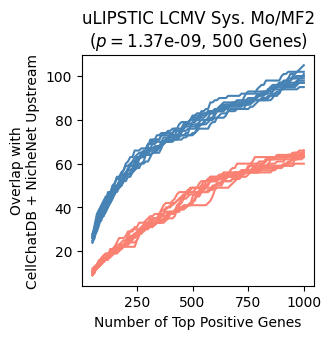

In [45]:
plt.figure(figsize=(3,3))
for i in range(10):
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey], label='Gloss Hallmark', color='steelblue')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey], label='Correlations', color='salmon')
plt.xlabel('Number of Top Positive Genes')
plt.ylabel('Overlap with\nCellChatDB + NicheNet Upstream'.format(mykey))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3)
plt.title(f'uLIPSTIC LCMV Sys. Mo/MF2\n($p = ${mytres:.2e}, 500 Genes)'.format(ctype))